In [3]:
from datasets import load_dataset

import numpy as np
import pandas as pd
import transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from huggingface_hub import login
import time
import datetime
import re
from tqdm import tqdm
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util
import random

from sklearn.metrics.pairwise import cosine_similarity

import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns





from openai import OpenAI


In [4]:

API_TOKEN = ''

login(token = API_TOKEN)

In [5]:
ds_persona = load_dataset("proj-persona/PersonaHub", "persona")

In [7]:
api_key=""

In [ ]:
enisear = pd.read_csv('../../enISEAR.tsv', delimiter= '\t')

    

def get_equal_sample(df, endsize: int, rand_state: int):
    """function to extract a sample of equal size of text per emotion

    Returns:
        dictionary: containing equal size of samples per emotion
    """

    sample_size_per_class = endsize // df['Prior_Emotion'].nunique()

    # Stratified sampling
    equal_sample = (
        df.groupby('Prior_Emotion', group_keys=False)
        .apply(lambda x: x.sample(sample_size_per_class, random_state=rand_state))
        .reset_index(drop=True)
    )

    return equal_sample[['Sentence', 'Prior_Emotion', 'Gender']]

enisear_examples = get_equal_sample(enisear, 7, 321)
enisear_examples
examples = []

for idx, row in enisear_examples.iterrows():
    text_for_example = f'''
"Prior_Emotion": "{row['Prior_Emotion']}",
"Sentence": "{row['Sentence']}",
'''
    examples.append({'emotion':row['Prior_Emotion'], 'Sentence':text_for_example})
examples

In [19]:
emotions = list(enisear['Prior_Emotion'].unique())
def create_prompt(tries):
    """Create prompt used for all LLMs

    Args: 
        tries: number of data elements wanted per emotion
    

    Retruns:
        complete prompt per text for the LLM with randomly selected example - 1-shot
    
    """
        
    persona_prompts = []

    for _ in range(tries):
        random_persona = random.randint(0, 200000)
        persona = ds_persona['train'][random_persona]['persona']

        for emotion in emotions:  # Loop over emotions
            
            persona_prompt = {}

            # SYSTEM: Set up the rules and persona
            synth_isear_prompt = f"""You are {persona}.
            You are currently participating in a psychological research study on emotions.  You must complete the following sentence: 
            'I felt {emotion} when ...',y describing an experience when you felt  {emotion}.
            Do not change the pattern of the sentence. Do not change the provided emotion.
            Your response must be elaborate and at least 30 words long. Do not reuse the example. Do not change the dictionary key format. 
            
            """
    
            
            example = next((e['Sentence'] for e in examples if e['emotion'] == emotion), None)

            messages = [
            {"role": "system", "content": synth_isear_prompt},
        
            {"role": "user", "content": f"Example for emotion: {emotion}"},
            {"role": "user", "content": example},
        
            {"role": "user", "content": 'Now, generate one response for this emotion. Follow the format strictly: {"Prior_Emotion": , "Sentence": }. Strictly follow all provided instructions!'}
            ]

            persona_prompt['persona'] = persona
            persona_prompt['emotion'] = emotion  # Store emotion separately
            persona_prompt['messages'] = messages


            persona_prompts.append(persona_prompt)

    return persona_prompts

In [20]:
messages = create_prompt(143)


In [21]:

def run_gpt(messages, model):


    """Run GPT API on dataframe

    Returns:
        dataframe: dataframe containing GPT's answers for every text
    """
    client = OpenAI(api_key=api_key)


    result_list = []

    for i in tqdm(messages, desc="Processing messages"):    

        try:

            response = client.responses.create(
                model=model,
                input=i['messages']
            )

            result_list.append(response.output_text)

            i['response']= response.output_text


        except Exception as e:
            
            error_message = f"Could not label this text due to the following error: {str(e)}"
            result_list.append([i['messages'], error_message])


    return messages, result_list

In [ ]:

messages.to_csv('messages_full_emotions.csv')

In [24]:

output_4o_mini_messages, output_4o_mini = run_gpt(messages, model = 'gpt-4o-mini')

output_4o_messages, output_4o = run_gpt(messages, model = 'gpt-4o')


Processing messages: 100%|██████████| 1001/1001 [45:11<00:00,  2.71s/it] 


In [33]:
def flatten_list(nested_list):
    """Flattens a nested list structure"""
    for item in nested_list:
        if isinstance(item, list):
            yield from flatten_list(item) 
        else:
            yield item

flattened_list = list(flatten_list(output_4o))
len(flattened_list)

1009

In [34]:
def find_nested_lists(data, path=""):
    """
    Recursively finds the location of nested lists in a list of data.

    Args:
        data (list): The main list to search.
        path (str): Path to the current element (used for recursion).
    
    Returns:
        List of paths where nested lists are found.
    """
    nested_paths = []

    for idx, item in enumerate(data):
        current_path = f"{path}[{idx}]"
        if isinstance(item, list):
            print(f"Nested list found at {current_path}: {item}")
            nested_paths.append(current_path)
            nested_paths.extend(find_nested_lists(item, current_path))
    
    return nested_paths

find_nested_lists(output_4o)


Nested list found at [598]: [[{'role': 'system', 'content': "You are A manufacturing plant manager seeking to improve operational efficiency and reduce waste through Lean Six Sigma.\n            You are currently taking part in an emotion-based study. You have to complete the following sentence: \n            'I felt Disgust when ...', by giving an elaborate account of a moment you have felt Disgust.\n            Do not change the pattern of this sentence. Do not change the provided emotion. Your generated answer should be elaborate and contain a minimun of 30 words. \n            Do not ever re-use the example. Do not change the order of keys in the dictionary or their spelling. Your answer should follow the provided dictionary format. \n            "}, {'role': 'user', 'content': 'Example for emotion: Disgust'}, {'role': 'user', 'content': '\n"Prior_Emotion": "Disgust",\n"Sentence": "I felt … when watching a television documentary about a child killer.",\n'}, {'role': 'user', 'conten

['[598]', '[598][0]', '[714]', '[714][0]']

In [35]:
indices_to_rerun = [598, 714]

messages_to_rerun = [messages[i] for i in indices_to_rerun]
_, rerun_results = run_gpt(messages_to_rerun, 'gpt-4o')

for idx, result in zip(indices_to_rerun, rerun_results):
    output_4o[idx] = result


Processing messages: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


In [48]:

def clean_entry(entry):

    """Normalizing all results to extract json format from string

    Args:
        entry (string): text from answer list of llm output

    Returns:
        json: entry in json format for easier handling
    """
    
    entry = re.sub(r'{\s*`{0,3}json\s*', '{', entry)
    entry = re.sub(r'`{0,3}\s*}', '}', entry)
    
    entry = re.sub(r'\bjson\b', '', entry)
    
    entry = entry.replace('\\n', ' ').replace("\\", '')
    entry = entry.replace('```', ' ').replace("\\", '')
    entry = re.sub(r'\s+', ' ', entry).strip()
    
    if not entry.startswith('{'):
        entry = '{' + entry
    if not entry.endswith('}'):
        entry += '}'

    if entry.startswith('{[') and entry.endswith(']}'):
        entry = entry[1:-1]

    return entry



def fix_json(entry):
    try:
        return json.loads(entry)  
    except json.JSONDecodeError:
        try:
            fixed_entry = ast.literal_eval(entry) 
            return json.loads(json.dumps(fixed_entry)) 
        except (SyntaxError, ValueError):
            return None  # 

def fix_all(output_list):
    

    output_list_cleaned = [clean_entry(i) for i in output_list]

    output_list_fixed = [fix_json(entry) for entry in output_list_cleaned if fix_json(entry) is not None]

    return output_list_fixed, output_list_cleaned



output_gpt4o_mini_fixed, output_gpt4o_mini_cleaned = fix_all(output_4o_mini)
output_gpt4o_fixed, output_gpt4o_cleaned = fix_all(output_4o)



In [49]:

def print_fail(model, cleaned):
    """Print entries that failed, to manually correct these final entries
    """

    failed_entries = [entry for entry in cleaned if fix_json(entry) is None]

    print(f"\n\n Unmatched entries {model}: ({len(failed_entries)}):")
    for entry in failed_entries: 
        print(entry)

#print_fail('Qwen3-32B', output_qwen3_32B_cleaned)
#print_fail('LlaMa 3.1', output_llama31_cleaned)
#print_fail('LlaMa 3.3', output_llama33_cleaned)

print_fail('GPT gpt4o', output_gpt4o_cleaned)
print_fail('GPT gpt4o-mini', output_gpt4o_mini_cleaned)




 Unmatched entries GPT gpt4o: (1):
{"Prior_Emotion": "Joy", "Sentence": "I felt Joy when I read the latest chapter of "Siren's Lament" and saw my favorite characters find happiness after so many struggles, it was truly rewarding."}


 Unmatched entries GPT gpt4o-mini: (0):


In [52]:
# # manually clean failed entries
#manually_fixed_gpt4o = [{"Prior_Emotion": "Joy", "Sentence": "I felt Joy when I read the latest chapter of Siren's Lament and saw my favorite characters find happiness after so many struggles, it was truly rewarding."}]
# # gpt4o_output_fixed.extend(manually_fixed_gpt4o_mini)
#output_gpt4o_fixed.extend(manually_fixed_gpt4o)

gpt4o_results = pd.DataFrame(output_gpt4o_fixed)
gpt4o_mini_results = pd.DataFrame(output_gpt4o_mini_fixed)
gpt4o_results['Prior_Emotion'].value_counts()


Prior_Emotion
Fear       143
Shame      143
Guilt      143
Disgust    143
Sadness    143
Anger      143
Joy        143
Name: count, dtype: int64

In [53]:
def words_stats(results):
    """Check if model correctly produced samples of ~ 30 words.

    """"
    results['Word_Count'] = results['Sentence'].apply(lambda x: len(x.split()))

    mean_length = results['Word_Count'].mean() 
    std_dev = results['Word_Count'].std()  
    quartiles = np.percentile(results['Word_Count'], [25, 50, 75])
    
    print(f"Mean Text Length: {mean_length:.2f} words")
    print(f"Standard Deviation: {std_dev:.2f} words")
    print(f"Quartiles (25th, 50th, 75th percentiles): {quartiles}")
    print(f"Max length of words: {results['Word_Count'].max()}")
    print(f"Min length of words: {results['Word_Count'].min()}")

words_stats(gpt4o_mini_results)
words_stats(gpt4o_results)


Mean Text Length: 28.91 words
Standard Deviation: 3.03 words
Quartiles (25th, 50th, 75th percentiles): [27. 29. 30.]
Max length of words: 44
Min length of words: 19
Mean Text Length: 31.92 words
Standard Deviation: 9.50 words
Quartiles (25th, 50th, 75th percentiles): [27. 29. 31.]
Max length of words: 84
Min length of words: 19


In [54]:

def remove_emotions_and_i_felt(text):

    
    text = text.lower()

    text = re.sub(r"\b(shame|disgust|guilt|joy|sadness|anger|fear|ashamed|disgusted|guilty|joyful|angry|sad|scared)\b", "", text)

    text = re.sub(r"\b(i felt|i feel|felt|feel)\b\s*", "", text, flags=re.IGNORECASE)
    return text.encode().decode('unicode_escape')


gpt4o_results['Sentence'] = gpt4o_results['Sentence'].apply(remove_emotions_and_i_felt)
gpt4o_mini_results['Sentence'] = gpt4o_mini_results['Sentence'].apply(remove_emotions_and_i_felt)


In [55]:
def dupli_vaL_cts(results):
    
    duplicates = results[results['Sentence'].duplicated(keep=False)]
    
    # Display duplicate rows
    print("Duplicate Rows:")
    print(duplicates)

    results['Prior_Emotion'].value_counts()
    
dupli_vaL_cts(gpt4o_results)
dupli_vaL_cts(gpt4o_mini_results)


Duplicate Rows:
Empty DataFrame
Columns: [Prior_Emotion, Sentence, Word_Count]
Index: []
Duplicate Rows:
Empty DataFrame
Columns: [Prior_Emotion, Sentence, Word_Count]
Index: []


In [56]:

gpt4o_results.to_csv('gpt4o_full_emotions.csv')
gpt4o_mini_results.to_csv('gpt4o_mini_full_emotions.csv')


## Testing word embeddings

### sentence transformer

In [1]:
from sentence_transformers import SentenceTransformer, util

from sklearn.metrics.pairwise import cosine_similarity

In [4]:

gpt4o = pd.read_csv('../full_emotions/gpt4o.csv')
gpt4o_mini = pd.read_csv('../full_emotions/gpt4o_mini.csv')
llama33 = pd.read_csv('../full_emotions/llama33.csv')
llama31 = pd.read_csv('../full_emotions/llama31.csv')
qwen3_32B = pd.read_csv('../full_emotions/qwen3_32B.csv')
qwen3_30BA3B = pd.read_csv('../full_emotions/qwen3_30BA3B.csv')
enisear = pd.read_csv('../full_emotions/enisear.csv')


In [15]:

model = SentenceTransformer("all-mpnet-base-v2")

synth_gpt4o = gpt4o['Sentence'].dropna().tolist()
synth_gpt4o_mini = gpt4o_mini['Sentence'].dropna().tolist()
enisear_lst = enisear['Sentence'].dropna().tolist()

synth_33 = llama33['Sentence'].dropna().tolist()
synth_31 = llama31['Sentence'].dropna().tolist()
synth_qwen3_32B = qwen3_32B['Sentence'].dropna().tolist()

# Compute embeddings
embeddings_gpt4o = model.encode(synth_gpt4o)
embeddings_gpt4o_mini = model.encode(synth_gpt4o_mini)
embeddings_isear = model.encode(enisear_lst)

embeddings_33 = model.encode(synth_33)
embeddings_31 = model.encode(synth_31)
embeddings_qwen3_32B = model.encode(synth_qwen3_32B)



# Compute within-dataset similarities (self-similarity)
similarities_gpt4o = cosine_similarity(embeddings_gpt4o)  
similarities_gpt4o_mini = cosine_similarity(embeddings_gpt4o_mini)  
similarities_enisear = cosine_similarity(embeddings_isear)  

similarities_31 = cosine_similarity(embeddings_31)  
similarities_33 = cosine_similarity(embeddings_33)  
similarities_qwen3_32B = cosine_similarity(embeddings_qwen3_32B)  



# Extract upper triangle values (unique pairs)
sim_gpt4o_values = similarities_gpt4o[np.triu_indices(len(synth_gpt4o), k=1)]
sim_gpt4o_mini_values = similarities_gpt4o_mini[np.triu_indices(len(synth_gpt4o_mini), k=1)]
sim_enisear_values = similarities_enisear[np.triu_indices(len(enisear_lst), k=1)]

sim_31_values = similarities_31[np.triu_indices(len(synth_31), k=1)]
sim_33_values = similarities_33[np.triu_indices(len(synth_33), k=1)]
sim_qwen3_32B_values = similarities_qwen3_32B[np.triu_indices(len(synth_qwen3_32B), k=1)]



Variance in enISEAR all-mpnet-base-v2: 0.0226
Variance in synthetic (gpt4o) all-mpnet-base-v2 : 0.0220
Variance in synthetic (gpt4o_mini) all-mpnet-base-v2 : 0.0255
Variance in synthetic (LlaMa 3.1 70B) all-mpnet-base-v2 : 0.0232
Variance in synthetic (LlaMa 3.3 70B) all-mpnet-base-v2 : 0.0223
Variance in synthetic (Qwen 3 32B) all-mpnet-base-v2 : 0.0201


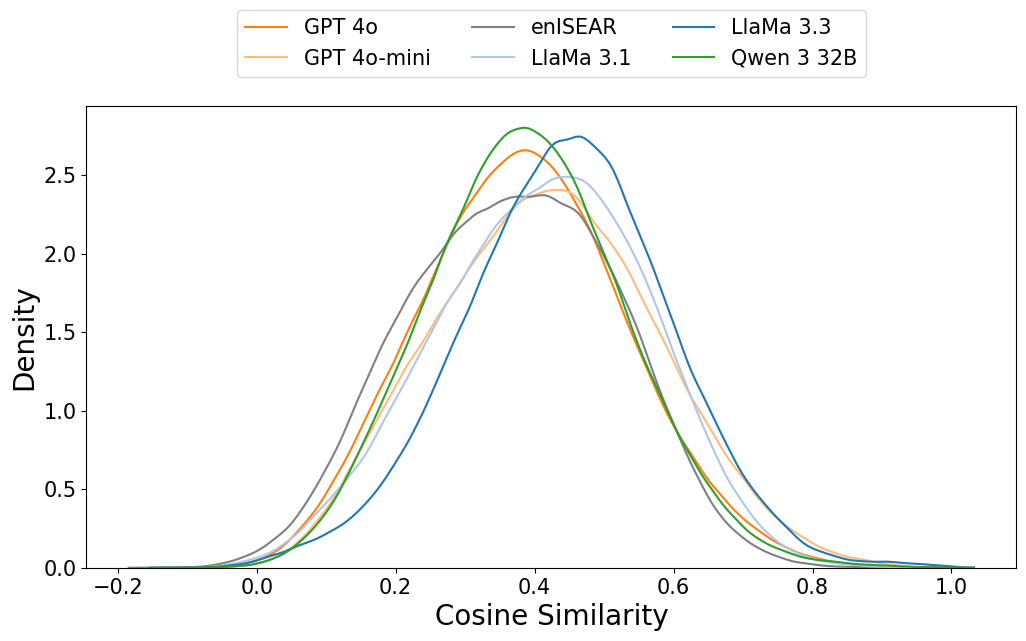

In [32]:
variance_gpt4o = np.var(sim_gpt4o_values)
variance_gpt4o_mini = np.var(sim_gpt4o_mini_values)
variance_isear = np.var(sim_enisear_values)

variance_31 = np.var(sim_31_values)
variance_33 = np.var(sim_33_values)
variance_qwen3_32B = np.var(sim_qwen3_32B_values)


print(f"Variance in enISEAR all-mpnet-base-v2: {variance_isear:.4f}")
print(f"Variance in synthetic (gpt4o) all-mpnet-base-v2 : {variance_gpt4o:.4f}")
print(f"Variance in synthetic (gpt4o_mini) all-mpnet-base-v2 : {variance_gpt4o_mini:.4f}")

print(f"Variance in synthetic (LlaMa 3.1 70B) all-mpnet-base-v2 : {variance_31:.4f}")
print(f"Variance in synthetic (LlaMa 3.3 70B) all-mpnet-base-v2 : {variance_33:.4f}")
print(f"Variance in synthetic (Qwen 3 32B) all-mpnet-base-v2 : {variance_qwen3_32B:.4f}")


plt.figure(figsize=(12, 6))

# Plot within-gpt4o similarities
sns.kdeplot(sim_gpt4o_values, label="GPT 4o", color = '#ff7f0e')

# Plot within-gpt4o_mini similarities
sns.kdeplot(sim_gpt4o_mini_values, label="GPT 4o-mini", color = '#ffbb78')

#Plot within-ensiear similarities
sns.kdeplot(sim_enisear_values, label="enISEAR", color = 'grey')

# Plot within-female similarities
sns.kdeplot(sim_31_values, label="LlaMa 3.1", color = '#aec7e8')

# Plot within-male similarities
sns.kdeplot(sim_33_values, label="LlaMa 3.3", color = '#1f77b4')



sns.kdeplot(sim_qwen3_32B_values, label="Qwen 3 32B", color = '#2ca02c')


plt.xlabel("Cosine Similarity", fontsize=20)
plt.ylabel("Density", fontsize = 20)
#plt.title("Comparison of Text Similarities using all-mpnet-base-v2")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.23),
    ncol=3,
    frameon=True, fontsize = 15
)
plt.tick_params(labelsize=15)
plt.savefig("../../../images/cos_sim_dist.pdf",
                bbox_inches="tight", dpi=300)
plt.show()


In [17]:
model_colors = {
    'llama33_label': '#1f77b4',
    'llama31_label': '#aec7e8',
    'gpt4o_label': '#ff7f0e',
    'gpt4o_mini_label': '#ffbb78',
    'qwen3_32B_label': '#2ca02c',
}

In [34]:
model_colors = {
    'enISEAR': 'grey', 
    'LLaMa 3.1': (0.5804, 0.4039, 0.7411),
    'LLaMa 3.3': (0.4792, 0.4039, 0.7411),
    'GPT 4o': (0.8392, 0.1529, 0.1569),
    'GPT 4o-mini': (0.8392, 0.5608, 0.1529),
    'Qwen 3 32B': (1.0, 0.5059, 0.7529)
}

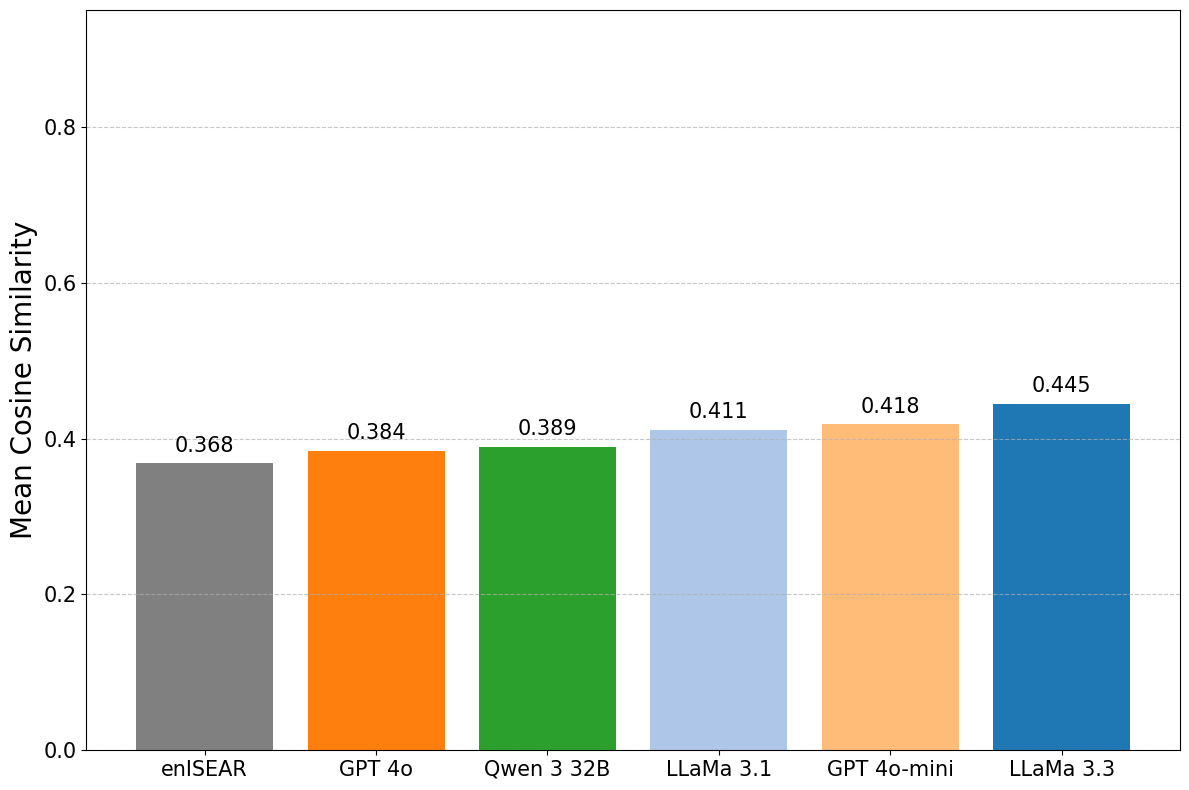

In [36]:
mean_isear = np.mean(sim_enisear_values)
mean_31 = np.mean(sim_31_values)
mean_33 = np.mean(sim_33_values)

mean_gpt4o = np.mean(sim_gpt4o_values)
mean_gpt4o_mini = np.mean(sim_gpt4o_mini_values)

mean_qwen=np.mean(sim_qwen3_32B_values)


labels = [
    "enISEAR",
    "LLaMa 3.1",
    "LLaMa 3.3",
    "GPT 4o", "GPT 4o-mini", "Qwen 3 32B"
]


means = [mean_isear, mean_31, mean_33, mean_gpt4o, mean_gpt4o_mini, mean_qwen]

colors = ['grey', '#aec7e8', '#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c']

combined = list(zip(labels, means, colors))
sorted_combined = sorted(combined, key=lambda x: x[1])  

sorted_labels, sorted_means, sorted_colors = zip(*sorted_combined)


plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_labels, sorted_means, capsize=6, color=sorted_colors)

for bar, value in zip(bars, sorted_means):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{value:.3f}",
        ha='center', va='bottom', fontsize=15
    )

plt.ylabel("Mean Cosine Similarity", fontsize=20)
plt.xticks(rotation=0, fontsize=20)
plt.tick_params(labelsize=15)
plt.ylim([0, 0.95])
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("../../../images/cos_sim_bars_sorted.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [37]:
data = {
    "enISEAR": sim_enisear_values,
    "LLaMa 3.1": sim_31_values,
    "LLaMa 3.3": sim_33_values,
    "GPT 4o":sim_gpt4o_values, "GPT 4o-mini":sim_gpt4o_mini_values, "Qwen 3 32B":sim_qwen3_32B_values
}

In [39]:
summary_stats = []

for name, values in data.items():
    stats = {
        "Dataset": name,
        "Mean": np.mean(values),
        "Median": np.median(values),
        "Std": np.std(values),
        "25th %": np.percentile(values, 25),
        "75th %": np.percentile(values, 75),
        "95th %": np.percentile(values, 95),

    }
    summary_stats.append(stats)

stats_df = pd.DataFrame(summary_stats)

stats_df = stats_df.round(4)

stats_df

,Dataset,Mean,Median,Std,25th %,75th %,95th %
0,enISEAR,0.3681,0.3707,0.1502,0.2581,0.4781,0.6081
1,LLaMa 3.1,0.4108,0.4169,0.1523,0.3049,0.5203,0.6513
2,LLaMa 3.3,0.4448,0.4474,0.1495,0.3467,0.5440,0.6860
3,GPT 4o,0.3844,0.3825,0.1483,0.2807,0.4837,0.6352
4,GPT 4o-mini,0.4181,0.4170,0.1597,0.3037,0.5281,0.6858
5,Qwen 3 32B,0.3890,0.3865,0.1417,0.2906,0.4831,0.6268


In [21]:

# Helper function to calculate all-vs-all cosine similarity with tqdm
def all_vs_all_cosine_similarity(emb1, emb2, chunk_size=1):
    """
    Compute all-vs-all cosine similarities with progress tracking.
    
    Args:
        emb1 (np.ndarray): Embeddings of the first dataset.
        emb2 (np.ndarray): Embeddings of the second dataset.
        chunk_size (int): Size of each chunk to process at once.

    Returns:
        np.ndarray: Flattened array of cosine similarities.
    """
    print("Calculating All-vs-All Cosine Similarities...")
    similarities = []
    for start_idx in tqdm(range(0, len(emb1), chunk_size), desc="Progress"):
        end_idx = min(start_idx + chunk_size, len(emb1))
        chunk_sim = cosine_similarity(emb1[start_idx:end_idx], emb2)
        similarities.append(chunk_sim.flatten())
    return np.concatenate(similarities)

# Calculate All-vs-All Cosine Similarities between embeddings
sim_31_vs_33 = all_vs_all_cosine_similarity(embeddings_31, embeddings_33)
sim_31_vs_qwen3_32B = all_vs_all_cosine_similarity(embeddings_31, embeddings_qwen3_32B)
sim_33_vs_qwen3_32B = all_vs_all_cosine_similarity(embeddings_33, embeddings_qwen3_32B)
sim_31_vs_enisear = all_vs_all_cosine_similarity(embeddings_31, embeddings_isear)
sim_33_vs_enisear = all_vs_all_cosine_similarity(embeddings_33, embeddings_isear)
sim_qwen3_32B_vs_enisear = all_vs_all_cosine_similarity(embeddings_qwen3_32B, embeddings_isear)




sim_31_vs_gpt4o = all_vs_all_cosine_similarity(embeddings_31, embeddings_gpt4o)
sim_33_vs_gpt4o = all_vs_all_cosine_similarity(embeddings_33, embeddings_gpt4o)
sim_gpt4o_vs_enisear = all_vs_all_cosine_similarity(embeddings_gpt4o, embeddings_isear)
sim_qwen3_32B_vs_gpt4o = all_vs_all_cosine_similarity(embeddings_qwen3_32B, embeddings_gpt4o)

sim_31_vs_gpt4o_mini = all_vs_all_cosine_similarity(embeddings_31, embeddings_gpt4o_mini)
sim_33_vs_gpt4o_mini = all_vs_all_cosine_similarity(embeddings_33, embeddings_gpt4o_mini)
sim_gpt4o_mini_vs_enisear = all_vs_all_cosine_similarity(embeddings_gpt4o_mini, embeddings_isear)
sim_qwen3_32B_vs_gpt4o_mini = all_vs_all_cosine_similarity(embeddings_qwen3_32B, embeddings_gpt4o_mini)


sim_gpt4o_vs_gpt4o_mini = all_vs_all_cosine_similarity(embeddings_gpt4o, embeddings_gpt4o_mini )


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 232.52it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 228.36it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:05<00:00, 188.60it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 210.64it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:05<00:00, 199.25it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 207.92it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:05<00:00, 198.83it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:05<00:00, 177.70it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:05<00:00, 188.89it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 225.62it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 223.81it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 232.60it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 224.85it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 223.02it/s]


Calculating All-vs-All Cosine Similarities...


Progress: 100%|██████████| 1001/1001 [00:04<00:00, 212.41it/s]


In [24]:
# Dictionary to store all the similarity scores with descriptive labels
similarity_dict = {
    "LLaMa 3.1 vs LLaMa 3.3": sim_31_vs_33,
    "LLaMa 3.1 vs Qwen 3 32B": sim_31_vs_qwen3_32B,
    "LLaMa 3.3 vs Qwen 3 32B": sim_33_vs_qwen3_32B,
    "LLaMa 3.1 vs enISEAR": sim_31_vs_enisear,
    "LLaMa 3.3 vs enISEAR": sim_33_vs_enisear,
    "Qwen 3 32B vs enISEAR": sim_qwen3_32B_vs_enisear,

    "LLaMa 3.1 vs GPT-4o": sim_31_vs_gpt4o,
    "LLaMa 3.3 vs GPT-4o": sim_33_vs_gpt4o,
    "GPT-4o vs enISEAR": sim_gpt4o_vs_enisear,
    "Qwen 3 32B vs GPT-4o": sim_qwen3_32B_vs_gpt4o,
    "LLaMa 3.1 vs GPT-4o-Mini": sim_31_vs_gpt4o_mini,
    "LLaMa 3.3 vs GPT-4o-Mini": sim_33_vs_gpt4o_mini,
    "GPT-4o-Mini vs enISEAR": sim_gpt4o_mini_vs_enisear,
    "Qwen 3 32B vs GPT-4o-Mini": sim_qwen3_32B_vs_gpt4o_mini,

    "GPT-4o vs GPT-4o-Mini": sim_gpt4o_vs_gpt4o_mini
}



mean_similarities = {k: v.mean() for k, v in similarity_dict.items()}

df_mean_similarities = pd.DataFrame(list(mean_similarities.items()), columns=['Model Pair', 'Mean Cosine Similarity'])
df_mean_similarities.sort_values(by='Mean Cosine Similarity', ascending=False, inplace=True)
df_mean_similarities


,Model Pair,Mean Cosine Similarity
0,LLaMa 3.1 vs LLaMa 3.3,0.425689
11,LLaMa 3.3 vs GPT-4o-Mini,0.420968
7,LLaMa 3.3 vs GPT-4o,0.406989
2,LLaMa 3.3 vs Qwen 3 32B,0.406436
10,LLaMa 3.1 vs GPT-4o-Mini,0.403431
14,GPT-4o vs GPT-4o-Mini,0.396667
13,Qwen 3 32B vs GPT-4o-Mini,0.394967
1,LLaMa 3.1 vs Qwen 3 32B,0.392339
6,LLaMa 3.1 vs GPT-4o,0.391804
9,Qwen 3 32B vs GPT-4o,0.381421


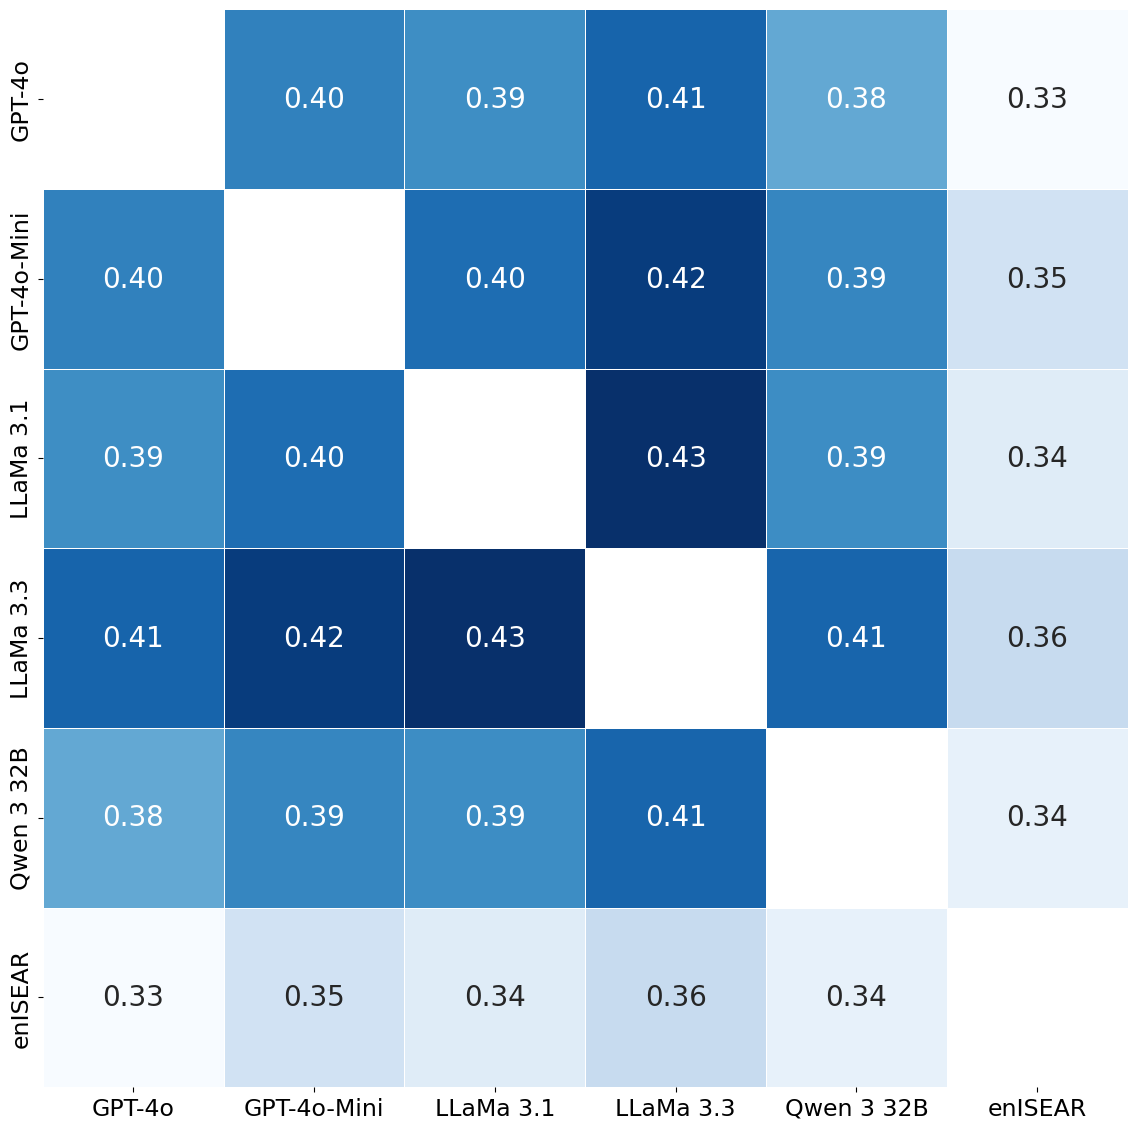

In [50]:

heatmap_data = pd.DataFrame()

for k, v in mean_similarities.items():
    model1, model2 = k.split(" vs ")
    heatmap_data.loc[model1, model2] = v
    heatmap_data.loc[model2, model1] = v  # Symmetric

heatmap_data = heatmap_data.astype(float)

heatmap_data = heatmap_data.sort_index(axis=0)  
heatmap_data = heatmap_data.sort_index(axis=1)  


# Plot
plt.figure(figsize=(14, 14))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 20}, cbar = False  
)
plt.tick_params(labelsize=17)
plt.savefig("../../../images/cos_sim_matrix.pdf", bbox_inches="tight", dpi=300)

plt.show()


In [26]:
heatmap_data

,GPT-4o,GPT-4o-Mini,LLaMa 3.1,LLaMa 3.3,Qwen 3 32B,enISEAR
GPT-4o,NaN,0.396667,0.391804,0.406989,0.381421,0.332251
GPT-4o-Mini,0.396667,NaN,0.403431,0.420968,0.394967,0.350385
LLaMa 3.1,0.391804,0.403431,NaN,0.425689,0.392339,0.343370
LLaMa 3.3,0.406989,0.420968,0.425689,NaN,0.406436,0.355431
Qwen 3 32B,0.381421,0.394967,0.392339,0.406436,NaN,0.339779
enISEAR,0.332251,0.350385,0.343370,0.355431,0.339779,NaN
